<a href="https://colab.research.google.com/github/romitbarua/MultiModalDeepFake/blob/main/TestingNotebooks/mbp_dlib_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install moviepy
!pip3 install imageio==2.4.1
!pip install imageio-ffmpeg
!pip install textgrid

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 3.3 MB 5.1 MB/s 
  Created wheel for imageio: filename=imageio-2.4.1-py3-none-any.whl size=3303886 sha256=b87d5ecf309e33bef3b20dfb7789c994b9f456082e2da07684b0666702ec28ba
  Stored in directory: /root/.cache/pip/wheels/46/20/07/7bb9c8c44e6ec2efa60fd0e6280094f53f65f41767ef69a5ee
Successfully built imageio
  Attempting uninstall: imageio
    Found existing installation: imageio 2.9.0
    Uninstalling imageio-2.9.0:
      Successfully uninstalled imageio-2.9.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 26.9 MB 1.3 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
import pandas as pd
import numpy as np
from moviepy.editor import *
import pickle
import textgrid
import os
import cv2
import dlib
from google.colab.patches import cv2_imshow
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import librosa
from scipy.io import wavfile
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)3129344/45929032 bytes (6.8%)7340032/45929032 bytes (16.0%)11632640/45929032 bytes (25.3%)15884288/45929032 bytes (34.6%)20217856/45929032 bytes (44.0%)24559616/45929032 bytes (53.5%)28934144/45929032 bytes (63.0%)33325056/45929032 bytes (72.6%)37740544/45929032 bytes (82.2%)42123264/45929032 bytes (91.7%)45929032/45929032 bytes (100.0%)
  Done
File saved as /root/.imageio/ffmpeg/ffmpeg-linux64-v3.3.1.


In [4]:
SYM_PATH = '/content/drive/MyDrive/DeepFakeDetection'
%cd $SYM_PATH
%pip install -e .

/content/drive/MyDrive/DeepFakeDetection
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining file:///content/drive/MyDrive/DeepFakeDetection
  Running setup.py develop for DeepFake


## Read in files

In [5]:
metadata_file = r'/content/drive/MyDrive/DeepFakeDetection/data/FakeAVCeleb_v1.2/wav2lip_metadata_updated.csv'
metadata_df = pd.read_csv(metadata_file)

In [6]:
mbp_file = r'/content/drive/MyDrive/DeepFakeDetection/data/FakeAVCeleb_v1.2/mbp_phonemes.pickle'
with open(mbp_file, 'rb') as handle:
  mbp_phonemes = pickle.load(handle)

## Dlib Space (test for 1 video)

In [7]:
from packages.DlibManager import DlibManager

predictor_path = '/content/drive/MyDrive/DeepFakeDetection/model/shape_predictor_68_face_landmarks.dat'
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(predictor_path)

In [8]:
metadata_df.loc[0]

video_id                                                       video 1
source                                                         id00076
target1                                                              -
target2                                                              -
method                                                            real
category                                                             A
type                                               RealVideo-RealAudio
race                                                           African
gender                                                             men
filename                                                     00109.mp4
directory_path       /content/drive/MyDrive/DeepFakeDetection/data/...
mp4_filepath         /content/drive/MyDrive/DeepFakeDetection/data/...
utterance_file       /content/drive/MyDrive/DeepFakeDetection/data/...
wav_filepath         /content/drive/MyDrive/DeepFakeDetection/data/...
audio_

In [9]:
video_id = metadata_df.video_id[0]
video_path = metadata_df.mp4_filepath[0]
wav_path = metadata_df.wav_filepath[0]

In [10]:
clip = VideoFileClip(video_path)

In [23]:
tol = 0.15
start = mbp_phonemes[video_id]['m_phonemes'][1].minTime - tol 
end = mbp_phonemes[video_id]['m_phonemes'][1].maxTime + tol 
start, end

(4.3, 4.630000000000001)

In [24]:
subclip = clip.subclip(start, end)

In [25]:
subclip.ipython_display(width = 360)

100%|██████████| 9/9 [00:00<00:00, 914.12it/s]


In [26]:
temp_file = '/content/drive/MyDrive/DeepFakeDetection/data/temp_storage/temp.mp4'
subclip.write_videofile(temp_file)

[MoviePy] >>>> Building video /content/drive/MyDrive/DeepFakeDetection/data/temp_storage/temp.mp4
[MoviePy] Writing audio in tempTEMP_MPY_wvf_snd.mp3


100%|██████████| 8/8 [00:00<00:00, 3748.68it/s]

[MoviePy] Done.
[MoviePy] Writing video /content/drive/MyDrive/DeepFakeDetection/data/temp_storage/temp.mp4



100%|██████████| 9/9 [00:00<00:00, 162.62it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/DeepFakeDetection/data/temp_storage/temp.mp4 



In [27]:
video = cv2.VideoCapture(temp_file)
dlib_video = DlibManager(predictor, detector, video)

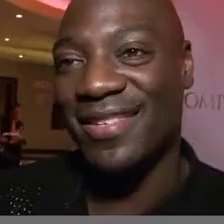

In [28]:
cv2_imshow(dlib_video.full_frames[1])

In [29]:
len(dlib_video.landmarks[1])

68

In [30]:
def calc_distance(coord_1, coord_2):
  return np.sqrt((coord_1[0] - coord_2[0])**2 + (coord_1[1] - coord_2[1])**2)

In [31]:
top_lip_idx = 62
bottom_lip_idx = 66

In [32]:
lip_distance = []
for landmark in dlib_video.landmarks:
  lip_distance.append(calc_distance(landmark[top_lip_idx], landmark[bottom_lip_idx]))

  FutureWarning



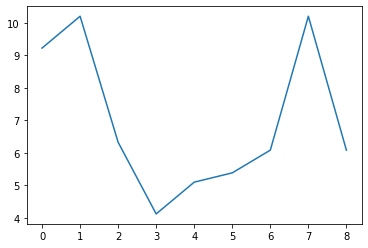

In [33]:
x = np.arange(0, len(dlib_video.full_frames), 1)
sns.lineplot(x, lip_distance)

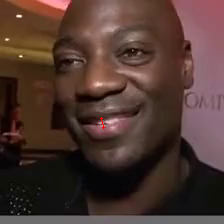

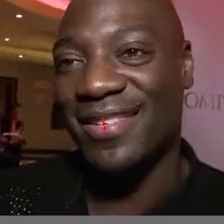

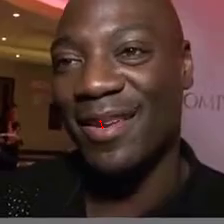

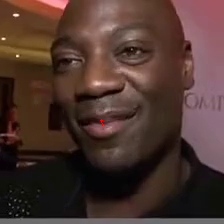

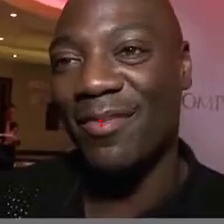

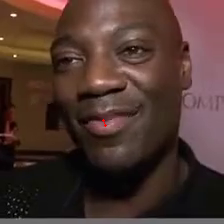

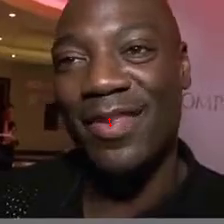

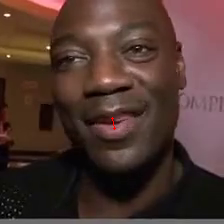

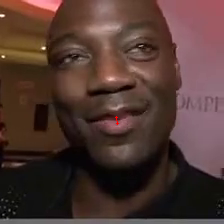

In [34]:
cap = cv2.VideoCapture(temp_file)
idx = 0
clean_frames = []

while(cap.isOpened()):
  # Capture frame-by-frame
  ret, frame = cap.read()
  if ret == True:
    #add landmarks to frame
    cv2.circle(frame, dlib_video.landmarks[idx][top_lip_idx], 1, (0, 0, 255), -1)
    cv2.circle(frame, dlib_video.landmarks[idx][bottom_lip_idx], 1, (0, 0, 255), -1)
    cv2.line(frame, dlib_video.landmarks[idx][top_lip_idx], dlib_video.landmarks[idx][bottom_lip_idx], (0, 0, 255))

    cv2_imshow(frame)
    clean_frames.append(frame)
    idx += 1


    if cv2.waitKey(25) & 0xFF == ord('q'):
      break

  else: 
    break

## Creating Functions